# Tutorial demonstrating verification of v1 SOI index against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import skill

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
%matplotlib inline

#### The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

#### The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [3]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# client

# Construct xarray objects for forecasts and observations

#### (The CAFE cookbook will replace these code blocks)

In [4]:
# Resampling details -----
resample_freq = '1MS' # Must be '1MS' for monthly
resample_method = 'mean'

# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/002_prmsl/'
obsv_filename = 'anl_surf125.002_prmsl.'

In [5]:
# Initialization dates (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2/2002','3/2002' , freq='1MS')  # Must be '1MS' for monthly

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years
no_leap = 2001
n_incr = len(pd.date_range('1/1/' + str(no_leap),
                           '12/1/' + str(no_leap+FCST_LENGTH-1),
                           freq=resample_freq)) # number of lead_time increments
lead_times = range(1,n_incr+1)

### Construct forecasts xarray object

In [6]:
# import pdb, traceback, sys

# ==================================================
# Initialize xarray object for first init_date -----
# ==================================================
with utils.timer():
    print(f'Gathering data for forecast started on {init_dates[0].month}-{init_dates[0].year}...')
    
    ds_fcst = xr.open_mfdataset(fcst_folder + 
                                '/yr' + str(init_dates[0].year) + 
                                '/mn' + str(init_dates[0].month) + 
                                '/OUTPUT.' + str(ensembles[0]) + 
                                '/' + fcst_filename, autoclose=True)
    ds_fcst.coords['ensemble'] = ensembles[0]

    for ensemble in ensembles[1:]:
        ds_temp = xr.open_mfdataset(fcst_folder + 
                                    '/yr' + str(init_dates[0].year) + 
                                    '/mn' + str(init_dates[0].month) + 
                                    '/OUTPUT.' + str(ensemble) + 
                                    '/' + fcst_filename, autoclose=True)
        # Concatenate along 'ensemble' dimension/coordinate -----
        ds_temp.coords['ensemble'] = ensemble
        ds_fcst = xr.concat([ds_fcst, ds_temp],'ensemble')

    # Resample to desired frequency and resave time as lead time -----
    ds_fcst = ds_fcst.resample(freq=resample_freq, dim='time', how=resample_method) \
                               .isel(time = range(len(lead_times)))
    ds_fcst = ds_fcst.rename({'time' : 'lead_time'})
    ds_fcst['lead_time'] = lead_times

    # Initialize 'init_date' coordinate -----
    ds_fcst.coords['init_date'] = init_dates[0]
    ds_fcst = ds_fcst.expand_dims('init_date')
    
# ==============================================
# Loop over remaining initialization dates -----
# ==============================================
for init_date in init_dates[1:]:
    with utils.timer():
        year = init_date.year
        month = init_date.month
        print(f'Gathering data for forecast started on {month}-{year}...')

        # There is a bug in xarray that causes an 'invalid type promotion' sometimes when concatenating 
        # The following while loop provides a work-around 
        more_ensembles = True
        first_chunk = True
        current_ensemble = 1

        while more_ensembles:
            try:
                # Initialize xarray object for first ensemble -----
                ds_temp1 = xr.open_mfdataset(fcst_folder + 
                                             '/yr' + str(year) + 
                                             '/mn' + str(month) + 
                                             '/OUTPUT.' + str(ensembles[current_ensemble-1]) + 
                                             '/' + fcst_filename, autoclose=True)
                ds_temp1.coords['ensemble'] = ensembles[current_ensemble-1]

                for ensemble in ensembles[current_ensemble:]:
                    ds_temp2 = xr.open_mfdataset(fcst_folder + 
                                                '/yr' + str(year) + 
                                                '/mn' + str(month) + 
                                                '/OUTPUT.' + str(ensemble) + 
                                                '/' + fcst_filename, autoclose=True)
                    # Concatenate along 'ensemble' dimension/coordinate -----
                    ds_temp2.coords['ensemble'] = ensemble
                    ds_temp1 = xr.concat([ds_temp1, ds_temp2],'ensemble')

                # try:
                if first_chunk:
                    ds_chunk = ds_temp1
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                # except:
                #     type, value, tb = sys.exc_info()
                #     traceback.print_exc()
                #     pdb.post_mortem(tb)

                more_ensembles = False
            except TypeError:
                if first_chunk:
                    ds_chunk = ds_temp1
                    first_chunk = False
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                current_ensemble = ensemble

        # Resample to desired frequency and resave time as lead time -----
        ds_chunk = ds_chunk.resample(freq=resample_freq, dim='time', how=resample_method) \
                           .isel(time = range(len(lead_times)))
        ds_chunk = ds_chunk.rename({'time' : 'lead_time'})
        ds_chunk['lead_time'] = lead_times

        # Concaneate along 'init_date' dimension/coordinate -----
        ds_chunk.coords['init_date'] = init_date
        ds_fcst = xr.concat([ds_fcst, ds_chunk],'init_date')

Gathering data for forecast started on 2-2002...
   Elapsed: 5.745598793029785 sec
Gathering data for forecast started on 3-2002...
   Elapsed: 5.703925848007202 sec


#### Rechunk

In [7]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_fcst = ds_fcst.chunk(chunks={'ensemble' : len(ensembles), 'lead_time' : len(lead_times)})

    # Overwrite init_dates in case didn't fully load -----
    init_dates = ds_fcst.init_date.values

   Elapsed: 0.46692991256713867 sec


### Construct observations xarray object

In [8]:
fcst_years = [pd.to_datetime(init_dates).year]
fcst_year_min = min(fcst_years)[0]
fcst_year_max = max(fcst_years)[-1] + FCST_LENGTH

# ===================================================
# Only load years for which forecast data exist -----
# ===================================================
with utils.timer():
    print(f'Gathering data for observations...')
    
    ds_temp1 = xr.open_mfdataset(obsv_folder + obsv_filename + str(fcst_year_min) + '*', 
                                 autoclose=True)
    for year_to_load in range(fcst_year_min+1,fcst_year_max+1):
        ds_temp2 = xr.open_mfdataset(obsv_folder + obsv_filename + str(year_to_load) + '*', 
                                     autoclose=True)
        ds_temp1 = xr.concat([ds_temp1, ds_temp2],'initial_time0_hours')

    # Standardize naming -----
    ds_temp1 = ds_temp1.rename({'initial_time0_hours':'time',
                                      'g0_lon_2':'lon',
                                      'g0_lat_1':'lat',
                                      'PRMSL_GDS0_MSL':'slp'})

    # Resample to desired frequency -----
    ds_temp1 = ds_temp1.resample(freq=resample_freq, dim='time', how=resample_method)
    
    # ===============================================
    # Stack to resemble ds_forecast coordinates -----
    # ===============================================
    # Initialize xarray object for first lead_time -----
    start_index = np.where(ds_temp1.time == np.datetime64(init_dates[0]))[0].item()
    ds_obsv = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))
    ds_obsv.coords['init_date'] = init_dates[0]
    ds_obsv = ds_obsv.expand_dims('init_date')
    ds_obsv = ds_obsv.rename({'time' : 'lead_time'})
    ds_obsv['lead_time'] = lead_times
    
    # Loop over remaining lead_time -----
    for init_date in init_dates[1:]:
        start_index = np.where(ds_temp1.time == np.datetime64(init_date))[0].item()
        ds_temp3 = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))

        # Concatenate along 'lead_time' dimension/coordinate -----
        ds_temp3 = ds_temp3.rename({'time' : 'lead_time'})
        ds_temp3['lead_time'] = lead_times
        ds_temp3.coords['init_date'] = init_date
        ds_obsv = xr.concat([ds_obsv, ds_temp3],'init_date') 

Gathering data for observations...
   Elapsed: 0.29718494415283203 sec


#### Rechunk

In [9]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_obsv = ds_obsv.chunk(chunks={'init_date' : len(init_dates)})

   Elapsed: 0.0033931732177734375 sec


# Compute the SOI index

#### Here defined simply as mslp Tahiti - Darwin

In [10]:
lat_Tahiti = 17.6509
lon_Tahiti = 149.4260

lat_Darwin = 12.4634
lon_Darwin = 130.8456

# Forecast -----
SOI_fcst = (utils.get_nearest_point(ds_fcst['slp'], lat_Tahiti, lon_Tahiti) - \
            utils.get_nearest_point(ds_fcst['slp'], lat_Darwin, lon_Darwin)).compute() * 100
    
# Observation -----
SOI_obsv = (utils.get_nearest_point(ds_obsv['slp'], lat_Tahiti, lon_Tahiti) - \
            utils.get_nearest_point(ds_obsv['slp'], lat_Darwin, lon_Darwin)).compute()

### Plot one initialization date

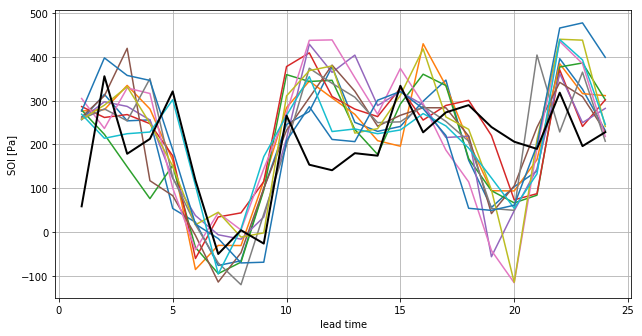

In [11]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(SOI_fcst['lead_time'],SOI_fcst.isel(init_date=[0]).squeeze())
ax.plot(SOI_obsv['lead_time'],SOI_obsv.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('SOI [Pa]');

# Compute some skill metrics

## (Continuous) ranked probability score

In [12]:
# Specify bins for computation of cdf -----
bins = np.linspace(0,500,50)

# Compute ranked probability score -----
rps = skill.compute_rps(SOI_fcst, SOI_obsv, bins=bins, indep_dims=None, ensemble_dim='ensemble') \
           .groupby('init_date.month').mean(dim='init_date')

   Elapsed: 0.021114110946655273 sec


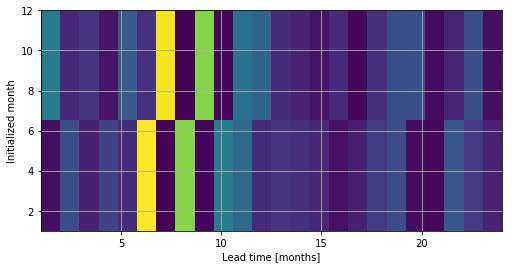

In [13]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.imshow(rps, extent=[1,24,1,12])
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Initialized month');

## Root mean squared error

In [14]:
with utils.timer():
    rms_error = skill.compute_rms_error(SOI_fcst, SOI_obsv, 
                                        indep_dims=None, ensemble_dim='ensemble') \
                     .groupby('init_date.month').mean(dim='init_date')

   Elapsed: 0.03355741500854492 sec


   Elapsed: 0.020782947540283203 sec


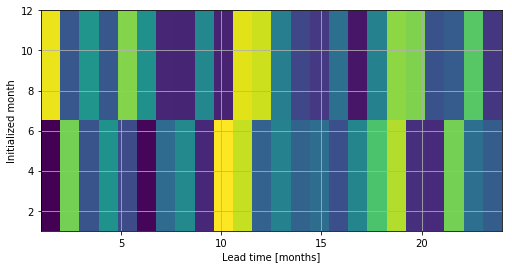

In [15]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.imshow(rms_error, extent=[1,24,1,12])
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Initialized month');

# Close dask client

In [16]:
# with utils.timer():
#     client.close()